In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.generate import *
from src.reasoner import *
from src.utils import *
from src.vis import *
import random 

seed = 2022

In [3]:
onto = load_ofn('local/out/dataset/pizza.ofn')
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
fact = Reasoner.from_onto(onto=onto, timeout=None)
    
C = onto.concept_by_name
R = onto.role_by_name
onto

Unsupported class expression ('SubClassOf', 'pizza:American', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('SubClassOf', 'pizza:AmericanHot', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('EquivalentClasses', 'pizza:Country', ('ObjectIntersectionOf', 'pizza:DomainConcept', ('ObjectOneOf', 'pizza:America', 'pizza:England', 'pizza:France', 'pizza:Germany', 'pizza:Italy')))
Unsupported class expression ('EquivalentClasses', 'pizza:InterestingPizza', ('ObjectIntersectionOf', 'pizza:Pizza', ('ObjectMinCardinality', '3', 'pizza:hasTopping')))
Unsupported class expression ('SubClassOf', 'pizza:MozzarellaTopping', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('SubClassOf', 'pizza:Napoletana', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('EquivalentClasses', 'pizza:RealItalianPizza', ('ObjectIntersection

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


<Onto 99 concepts, 4 roles, 287 axioms>

In [4]:
queries, answers, qset = [], [], set()
concepts = list(range(onto.n_concepts)) + [TOP, BOT]

for c in concepts:
    for d in concepts:
        append_unique((SUB, c, d), queries, qset)

for query in queries:
    answers.append(float(fact.check_axiom(query)))

rng = np.random.default_rng(seed)
queries, answers = jointshuffle(rng, queries, answers)

print(len(answers))
print(np.mean(answers))

10201
0.09459856876776787


In [5]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data[0],
    'X': data[1],
    'y': data[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col], random_state=seed)
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col], random_state=seed)

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()

In [7]:
rng = np.random.default_rng(seed)
T.manual_seed(seed)
random.seed(seed)
reasoner = ModifiedNeuralReasoner(emb_size=10, hidden_size=16, onto=onto)
print('head params', paramcount(reasoner.head))
print('embs params', paramcount(reasoner.embs))

log = train_mod(data_tr, data_vl, reasoner.head, [reasoner.embs], freeze_reasoner=False,
            epoch_count=23, batch_size=32, lr_reasoner=0.0014, lr_encoder=0.0013, identities_weight=0.3, identitity_weight_decay=0.96)

head params 3283
embs params 1430
train epoch 00/23 | batch 019/192 | loss 3.8056 | elapsed 0.24s

train epoch 00/23 | batch 193/192 | loss 3.8038 | val loss 0.7433 | acc 0.0946 | f1 0.1729 | prec 0.0946 | recall 1.0000 | roc auc 0.5023 | pr auc 0.1075 | elapsed 2.40s
train epoch 01/23 | batch 193/192 | loss 2.3326 | val loss 0.4982 | acc 0.8015 | f1 0.3642 | prec 0.2613 | recall 0.6010 | roc auc 0.7780 | pr auc 0.4779 | elapsed 4.44s
train epoch 02/23 | batch 193/192 | loss 1.3562 | val loss 0.2764 | acc 0.9475 | f1 0.7116 | prec 0.7416 | recall 0.6839 | roc auc 0.8938 | pr auc 0.7609 | elapsed 4.11s
train epoch 03/23 | batch 193/192 | loss 0.9613 | val loss 0.2436 | acc 0.9446 | f1 0.7050 | prec 0.7105 | recall 0.6995 | roc auc 0.9172 | pr auc 0.7950 | elapsed 4.52s
train epoch 04/23 | batch 193/192 | loss 0.7363 | val loss 0.2089 | acc 0.9314 | f1 0.6585 | prec 0.6221 | recall 0.6995 | roc auc 0.9112 | pr auc 0.7732 | elapsed 4.38s
train epoch 05/23 | batch 193/192 | loss 0.6129 | val loss 0.2154 | acc 0.9265 | f1 0.6445 | prec 0.5939 | recall 0.7047 | roc auc 0.9047 | pr auc 0.7

             mean  std     micro
acc      0.954434  NaN  0.954434
prec     0.706612  NaN  0.706612
recall   0.886010  NaN  0.886010
f1       0.786207  NaN  0.786207
auc_roc  0.973891  NaN  0.973891
auc_pr   0.910728  NaN  0.910728


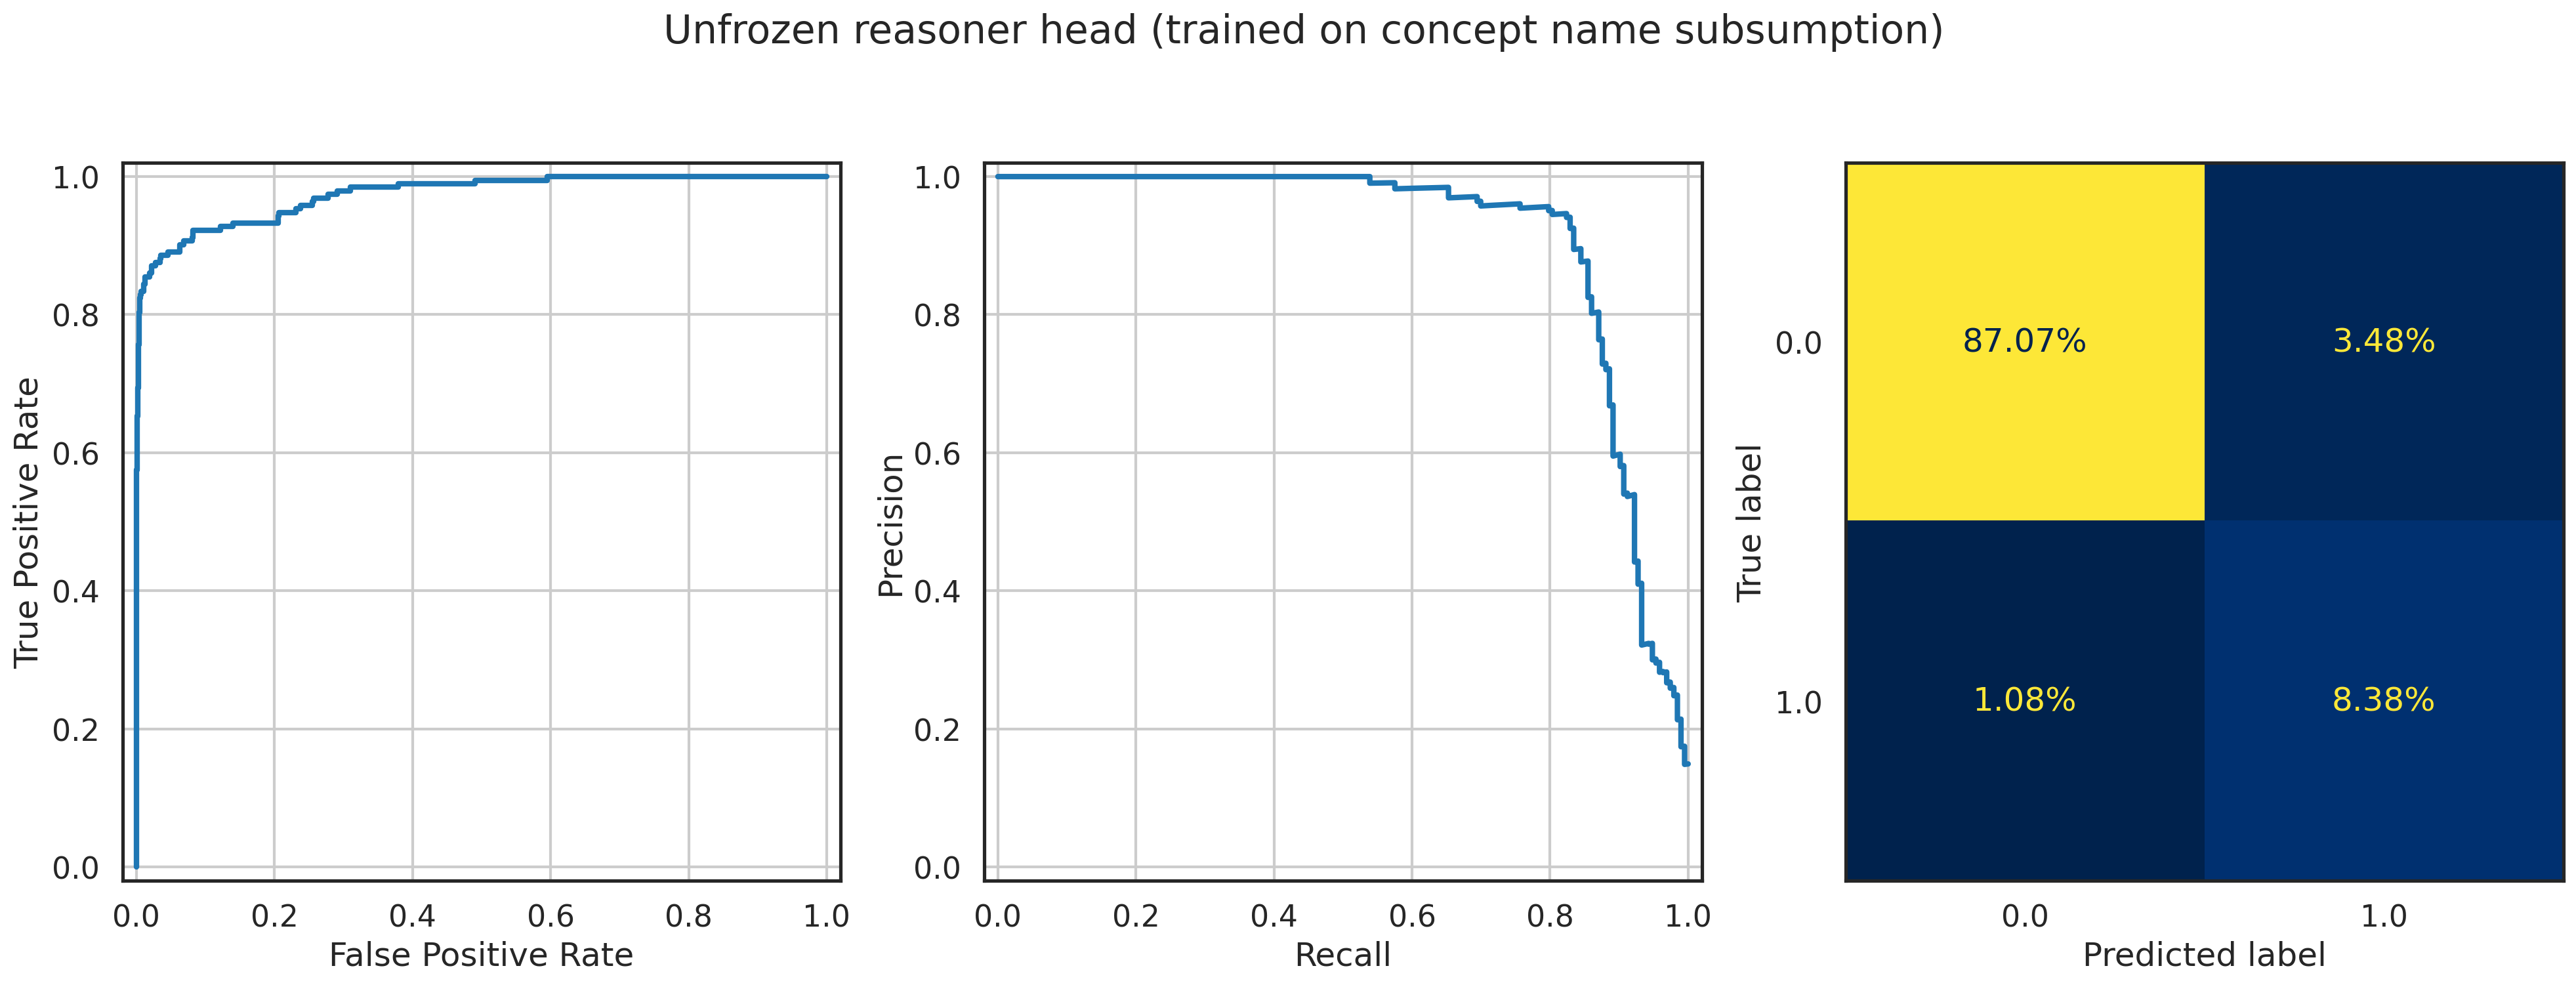

In [19]:
with T.no_grad():
    reasoner.eval()
    _, y_te, Y_te = eval_batch_mod(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)

print(report([onto], y_te, Y_te, idx_te))
plt.suptitle('Unfrozen reasoner head (trained on concept name subsumption)')
plt.show()

In [9]:
from random import random

input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]
print(input)
print(reasoner.head.and_nn(im_mod( input, input)))
F.l1_loss(input, reasoner.head.and_nn(im_mod(input, input)))

tensor([ 0.0120, -0.1565, -0.0652, -0.0620, -0.3618,  0.0825, -0.1496,  0.0616,
         0.3428,  0.2442], grad_fn=<SelectBackward0>)
tensor([ 0.0751, -0.1601,  0.0424, -0.0106, -0.1574, -0.0204, -0.0977,  0.0790,
         0.2906,  0.1822], grad_fn=<AddBackward0>)


tensor(0.0716, grad_fn=<L1LossBackward0>)

In [10]:
input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.bot_concept[0])
print(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)))
print(F.l1_loss(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)), reasoner.head.bot_concept[0]))

tensor([ 0.2120, -0.1779,  0.1736,  0.1691,  0.1701, -0.0871, -0.2665,  0.0720,
         0.2869, -0.2334], grad_fn=<SelectBackward0>)
tensor([ 0.2184, -0.1779,  0.1836,  0.1715,  0.1899, -0.1019, -0.2659,  0.0660,
         0.2847, -0.2343], grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<L1LossBackward0>)


In [11]:
input = T.rand(10)

print(input)
print(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)))
print(F.l1_loss(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)), input))


tensor([0.9539, 0.0068, 0.5205, 0.5756, 0.2419, 0.8341, 0.8455, 0.3658, 0.0257,
        0.6688])
tensor([ 0.3608,  0.0341,  0.0815,  0.0376,  0.0539,  0.3751,  0.5333,  0.0313,
        -0.0899,  0.2771], grad_fn=<AddBackward0>)
tensor(0.3398, grad_fn=<L1LossBackward0>)


In [12]:
input = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.bot_concept[0])
output = reasoner.head.and_nn(im_mod(reasoner.head.not_nn(input), input))
print(output)
print(F.l1_loss(output, input))


tensor([ 0.2120, -0.1779,  0.1736,  0.1691,  0.1701, -0.0871, -0.2665,  0.0720,
         0.2869, -0.2334], grad_fn=<SelectBackward0>)
tensor([ 0.1743, -0.1132,  0.0910,  0.1227,  0.1005, -0.0009, -0.2751,  0.0704,
         0.2262, -0.1841], grad_fn=<AddBackward0>)
tensor(0.1982, grad_fn=<L1LossBackward0>)


In [13]:
print(reasoner.head.bot_concept[0])
output = reasoner.head.not_nn(reasoner.head.top_concept[0])
print(output)
print(F.mse_loss(reasoner.head.bot_concept[0], output))

tensor([ 0.2120, -0.1779,  0.1736,  0.1691,  0.1701, -0.0871, -0.2665,  0.0720,
         0.2869, -0.2334], grad_fn=<SelectBackward0>)
tensor([ 0.2115, -0.1782,  0.1738,  0.1689,  0.1697, -0.0865, -0.2663,  0.0722,
         0.2865, -0.2334], grad_fn=<SqueezeBackward3>)
tensor(1.2321e-07, grad_fn=<MseLossBackward0>)


In [14]:
print(reasoner.head.top_concept[0])
output = reasoner.head.not_nn(reasoner.head.bot_concept[0])
print(output)
print(F.mse_loss(reasoner.head.top_concept[0], output))

tensor([-0.2261, -0.0815,  0.0939, -0.0912,  0.2442,  0.2465,  0.2750, -0.0422,
        -0.5688,  0.4045], grad_fn=<SelectBackward0>)
tensor([-0.2261, -0.0811,  0.0939, -0.0915,  0.2447,  0.2464,  0.2756, -0.0424,
        -0.5687,  0.4042], grad_fn=<SqueezeBackward3>)
tensor(1.1406e-07, grad_fn=<MseLossBackward0>)


In [15]:
input1 = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]
input2 = reasoner.embs.concepts[int(np.round(random() * reasoner.embs.n_concepts, 0) - 1)]

print(reasoner.head.and_nn(im_mod(input2,input1)))
print(reasoner.head.and_nn(im_mod(input1,input2)))

F.mse_loss(reasoner.head.and_nn(im_mod(input2,input1)) , reasoner.head.and_nn(im_mod(input1,input2)))

tensor([ 0.2376, -0.1655,  0.0687, -0.0607, -0.0219,  0.0816, -0.1355, -0.0227,
         0.1606, -0.1098], grad_fn=<AddBackward0>)
tensor([ 0.2450, -0.1754,  0.0580, -0.0557, -0.0291,  0.0867, -0.1529, -0.0050,
         0.1516, -0.0883], grad_fn=<AddBackward0>)


tensor(0.0002, grad_fn=<MseLossBackward0>)

In [16]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te_2 = np.array(Y_te)
y_te_2 = np.array(y_te)
X_te_2 = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te_2 - y_te_2) > 0.3

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te_2[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rekord': np.arange(len(X_te_2))[błędne_predykcje],
    'Prawdziwa Etykieta': y_te_2[błędne_predykcje],
    'Predykcja': Y_te_2[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'Feature_{i}' for i in range(X_te_2.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)

print(wyniki)

     Rekord  Prawdziwa Etykieta  Predykcja  Feature_0  Feature_1  Feature_2
0         2                 1.0   0.000488          0         77         41
1         4                 1.0   0.000550          0          7          7
2         7                 0.0   0.868054          0          4         90
3        13                 0.0   0.953445          0         70         59
4        23                 0.0   0.559127          0         65         63
..      ...                 ...        ...        ...        ...        ...
118    1938                 0.0   0.361661          0         94         96
119    1977                 0.0   0.854657          0         76         60
120    1985                 1.0   0.086095          0         27         97
121    2008                 0.0   0.960137          0         84         28
122    2020                 0.0   0.717667          0          0         78

[123 rows x 6 columns]


In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(wyniki)

     Rekord  Prawdziwa Etykieta     Predykcja  Feature_0  Feature_1  Feature_2
0         2                 1.0  4.881895e-04          0         77         41
1         4                 1.0  5.501117e-04          0          7          7
2         7                 0.0  8.680544e-01          0          4         90
3        13                 0.0  9.534450e-01          0         70         59
4        23                 0.0  5.591270e-01          0         65         63
5        55                 0.0  9.908645e-01          0         54         48
6        60                 0.0  9.116691e-01          0         66         90
7        72                 0.0  3.084788e-01          0         21         24
8        75                 0.0  3.465024e-01          0         94         11
9        89                 1.0  8.653106e-02          0         29         40
10      124                 0.0  9.247070e-01          0          3         10
11      142                 0.0  6.639647e-01       

In [18]:

print(T.round( T.matmul( reasoner.head.not_nn.weight,reasoner.head.not_nn.weight) *100)/100)

tensor([[1., 0., 0., -0., 0., 0., 0., 0., 0., -0.],
        [-0., 1., -0., -0., -0., -0., -0., -0., -0., 0.],
        [-0., -0., 1., 0., -0., 0., -0., -0., -0., -0.],
        [0., -0., 0., 1., -0., -0., -0., -0., -0., 0.],
        [0., 0., -0., -0., 1., 0., -0., -0., -0., 0.],
        [-0., 0., -0., -0., -0., 1., -0., -0., -0., 0.],
        [0., -0., -0., 0., 0., -0., 1., -0., 0., 0.],
        [0., -0., 0., 0., -0., -0., -0., 1., 0., -0.],
        [0., 0., -0., -0., -0., 0., 0., -0., 1., 0.],
        [0., -0., 0., -0., 0., 0., -0., 0., 0., 1.]], grad_fn=<DivBackward0>)
